In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
# nvcc version 확인
!nvcc -V

zsh:1: command not found: nvcc


In [2]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [24]:
# 필수 Package import
import os
import glob
import random
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

In [25]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "0"

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn.functional as F

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
device

device(type='cpu')

In [19]:
print('Device:', device)
print('Count of using GPUs:', torch.cuda.device_count())

Device: cpu
Count of using GPUs: 0


train [1362, 773, 799, 494]
val [0, 445, 653, 471]
test [174, 399, 65, 14]


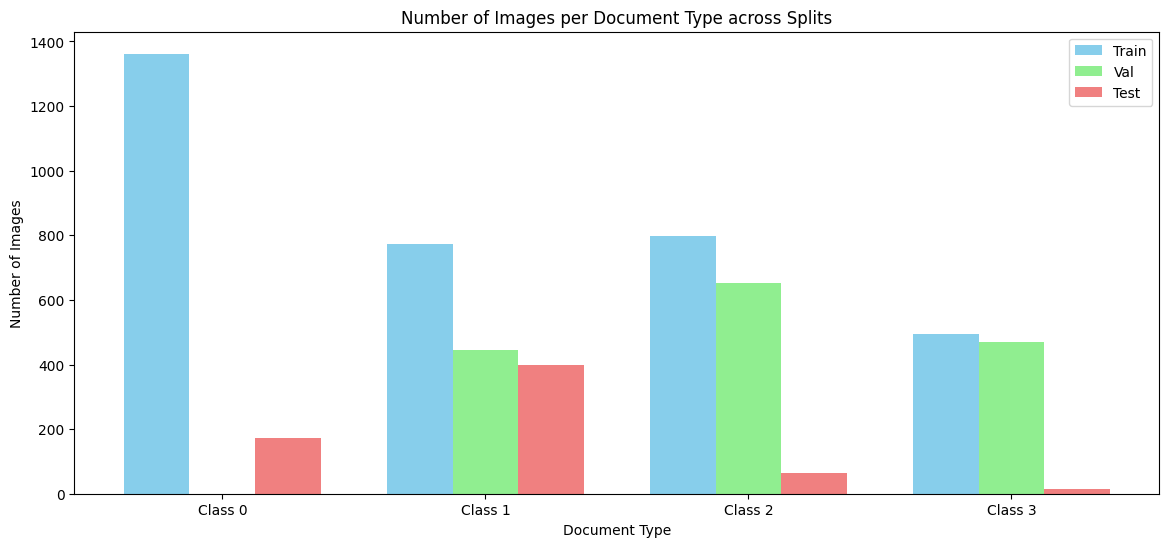

In [21]:
# 이미지 경로와 annotations 경로 설정
root_dir = '/content/drive/MyDrive/fastcampus/image_classification/domain/3'
splits = ['train', 'val', 'test']

    # Mu03(갈비뼈골절)
    # Mu05(슬개골탈구)
    # Mu06(전십자인대파열)
    # Mu07(추간판질환)

disease_to_label = {
    'Mu03': 0,
    'Mu05': 1,
    'Mu06': 2,
    'Mu07': 3,
}

# 스플릿과 클래스(문서 유형)별 이미지 수를 저장할 딕셔너리
split_class_counts = {split: {label: 0 for label in disease_to_label.values()} for split in splits}

for split in splits:
    annotation_paths = glob.glob(f'{root_dir}/{split}/annotations/*.json')
    for annotation_path in annotation_paths:
        with open(annotation_path, 'r') as f:
            annotation = json.load(f)
        disease_name = annotation.get('metadata', [{}]).get('Disease-Name', None)

        # disease_name이 disease_name_to_label의 키 중 하나를 포함하는지 확인
        for key, label in disease_to_label.items():
            if disease_name and key in disease_name:
                split_class_counts[split][label] += 1
                break  # 일치하는 첫 번째 항목을 찾으면 루프 탈출

# 클래스별 이미지 수 출력 및 바 그래프 생성
plt.figure(figsize=(14, 6))
colors = ['skyblue', 'lightgreen', 'lightcoral', 'black', 'red', 'blue', 'yellow']
for idx, split in enumerate(splits):
    counts = [split_class_counts[split][label] for label in sorted(split_class_counts[split].keys())]
    print(split, counts)
    plt.bar([x + idx*0.25 for x in range(len(counts))], counts, color=colors[idx], width=0.25, label=f'{split.capitalize()}')

plt.title('Number of Images per Document Type across Splits')
plt.xlabel('Document Type')
plt.ylabel('Number of Images')
plt.xticks([x + 0.25 for x in range(len(disease_to_label))], [f'Class {x}' for x in sorted(disease_to_label.values())])
plt.legend()
plt.show()

In [ ]:
def display_sample_images(annotation_paths, disease_to_label, num_samples=1):
    sample_images = {label: [] for label in disease_to_label.values()}  # 각 클래스별 샘플 이미지 경로를 저장할 딕셔너리

    for annotation_path in annotation_paths:
        with open(annotation_path, 'r') as f:
            annotation = json.load(f)
        disease_name = annotation.get('metadata', [{}]).get('Disease-Name', None)

        # Dynamically set the base path for images based on the annotation path
        split_path = os.path.normpath(annotation_path).split(os.sep)
        split_index = split_path.index('annotations') - 1
        split_name = split_path[split_index]
        image_paths = f'/content/drive/MyDrive/fastcampus/image_classification/domain/3/{split_name}/images/'

        image_path = annotation.get('fileName')
        # Split the file name and extension
        base_file_name = image_path.rsplit('.', 1)[0]
        # Change the extension to .jpg
        image_path = image_paths + base_file_name + '.jpg'

        if disease_name and disease_name in disease_to_label and image_path:
            label = disease_to_label[disease_name]
            if len(sample_images[label]) < num_samples:  # 각 클래스별로 지정된 수의 샘플만 선택
                sample_images[label].append(image_path)


    # 샘플 이미지가 있는 클래스 수를 정확히 계산
    num_classes_with_images = sum(len(images) > 0 for images in sample_images.values())

    if num_classes_with_images > 0:
        fig, axs = plt.subplots(1, num_classes_with_images, figsize=(15, 5), squeeze=False)
        axs = axs.flatten()  # 2D 배열을 1D 배열로 변환

        idx = 0  # Initialize index for axs
        for label, images in sample_images.items():
            if images:  # 이미지가 실제로 있을 경우에만 로드 및 표시
                image = Image.open(images[0])  # 첫 번째 샘플 이미지 로드
                axs[idx].imshow(image)
                axs[idx].set_title(f'Class {label}')
                axs[idx].axis('off')
                idx += 1  # Increment index after plotting each class

        plt.tight_layout()
        plt.show()
    else:
        print("No sample images available.")

Train Sample Images:


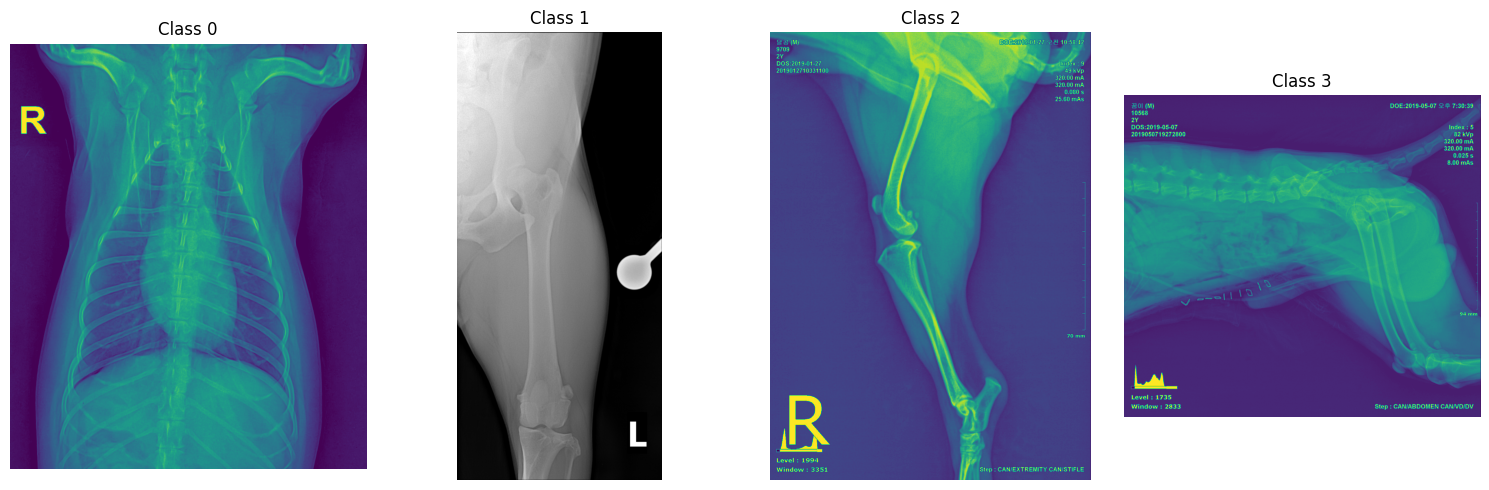

Val Sample Images:


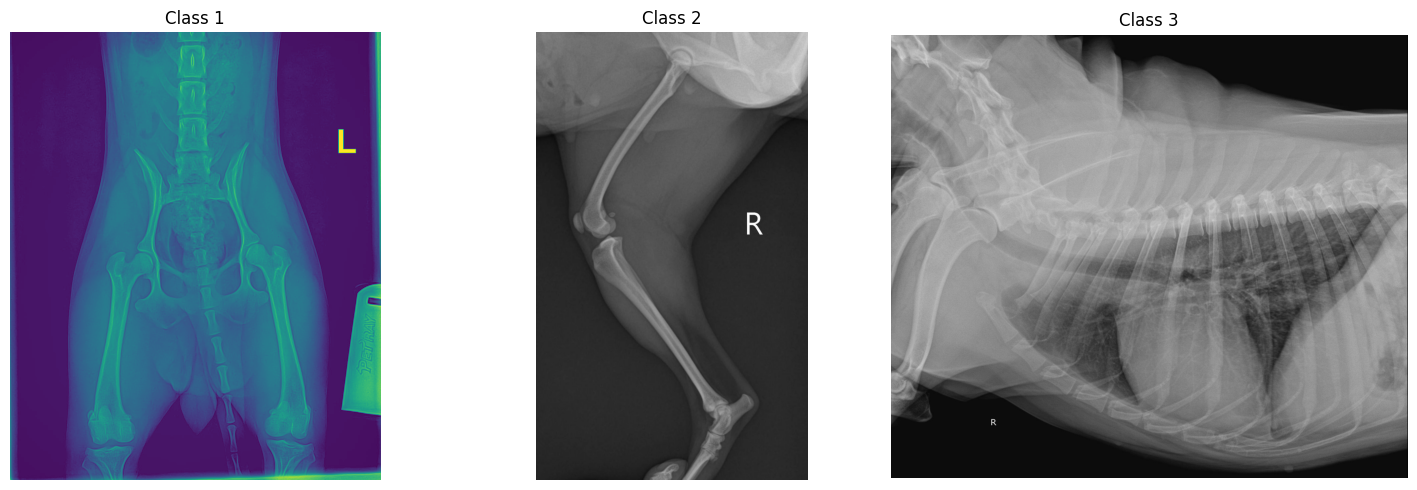

Test Sample Images:


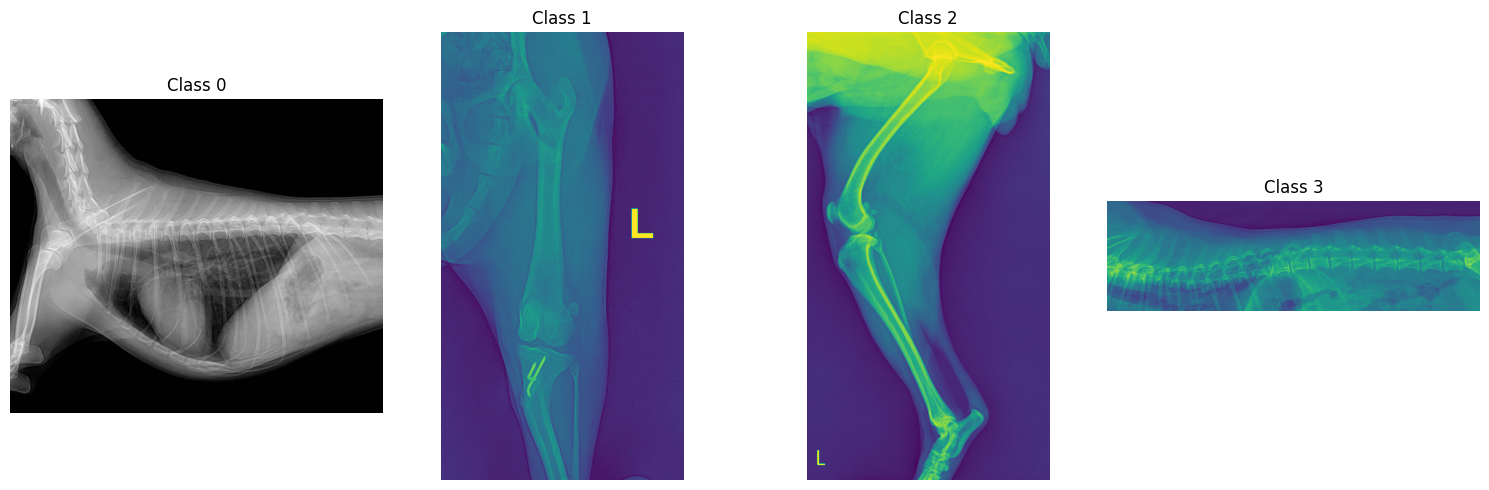

In [ ]:
# 모든 splits에 대해 샘플 이미지 출력
for split in splits:
    print(f"{split.capitalize()} Sample Images:")
    annotation_paths = glob.glob(f'{root_dir}/{split}/annotations/*.json')
    display_sample_images(annotation_paths, disease_to_label, num_samples=1)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        # Mu03(갈비뼈골절)
        # Mu05(슬개골탈구)
        # Mu06(전십자인대파열)
        # Mu07(추간판질환)

        self.disease_to_label = {
            'Mu03': 0,
            'Mu05': 1,
            'Mu06': 2,
            'Mu07': 3,
        }

        image_dir = os.path.join(root_dir, 'images')
        annotation_dir = os.path.join(root_dir, 'annotations')
        for img_filename in os.listdir(image_dir):
            img_path = os.path.join(image_dir, img_filename)
            annotation_path = os.path.join(annotation_dir, os.path.splitext(img_filename)[0] + '.json')

            # 애너테이션 파일 로드
            with open(annotation_path, 'r') as f:
                annotation = json.load(f)

            # disease_name 추출
            disease_name = annotation.get('metadata', [{}]).get('Disease-Name', None)

            # disease_name을 기반으로 레이블 결정
            label = self.disease_to_label.get(disease_name, -1)  # disease_name이 매핑되지 않은 경우 -1

            if label != -1:  # 유효한 레이블이 있는 경우에만 샘플 추가
                self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
transform = transforms.Compose([
    transforms.Resize((456, 456)),
    transforms.RandomHorizontalFlip(),  # Flips the image horizontally with a probability of 0.5
    transforms.RandomRotation(20),  # Randomly rotates the image by a degree selected between -20 and 20
    transforms.ToTensor(),
])

In [ ]:
train_dataset = CustomDataset(root_dir='/content/drive/MyDrive/fastcampus/image_classification/domain/3/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [ ]:
val_dataset = CustomDataset(root_dir='/content/drive/MyDrive/fastcampus/image_classification/domain/3/val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [ ]:
def imshow(img, labels, size=(20, 20)):
    img = img.numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)  # 값이 0과 1 사이에 오도록 클리핑
    plt.figure(figsize=size)
    plt.imshow(img)
    plt.axis('off')

    # 이미지 위에 레이블 번호 출력
    rows = 2
    cols = 4
    for i, label in enumerate(labels[:8]):  # 첫 8개의 이미지에 대해서만 실행
        x = (i % cols) * (img.shape[1] // cols) + (img.shape[1] // cols) // 2
        y = (i // cols) * (img.shape[0] // rows) + (img.shape[0] // rows) // 2
        plt.text(x, y, f'{label.item()}', color='red', fontsize=14, ha='center', va='center')

    plt.show()

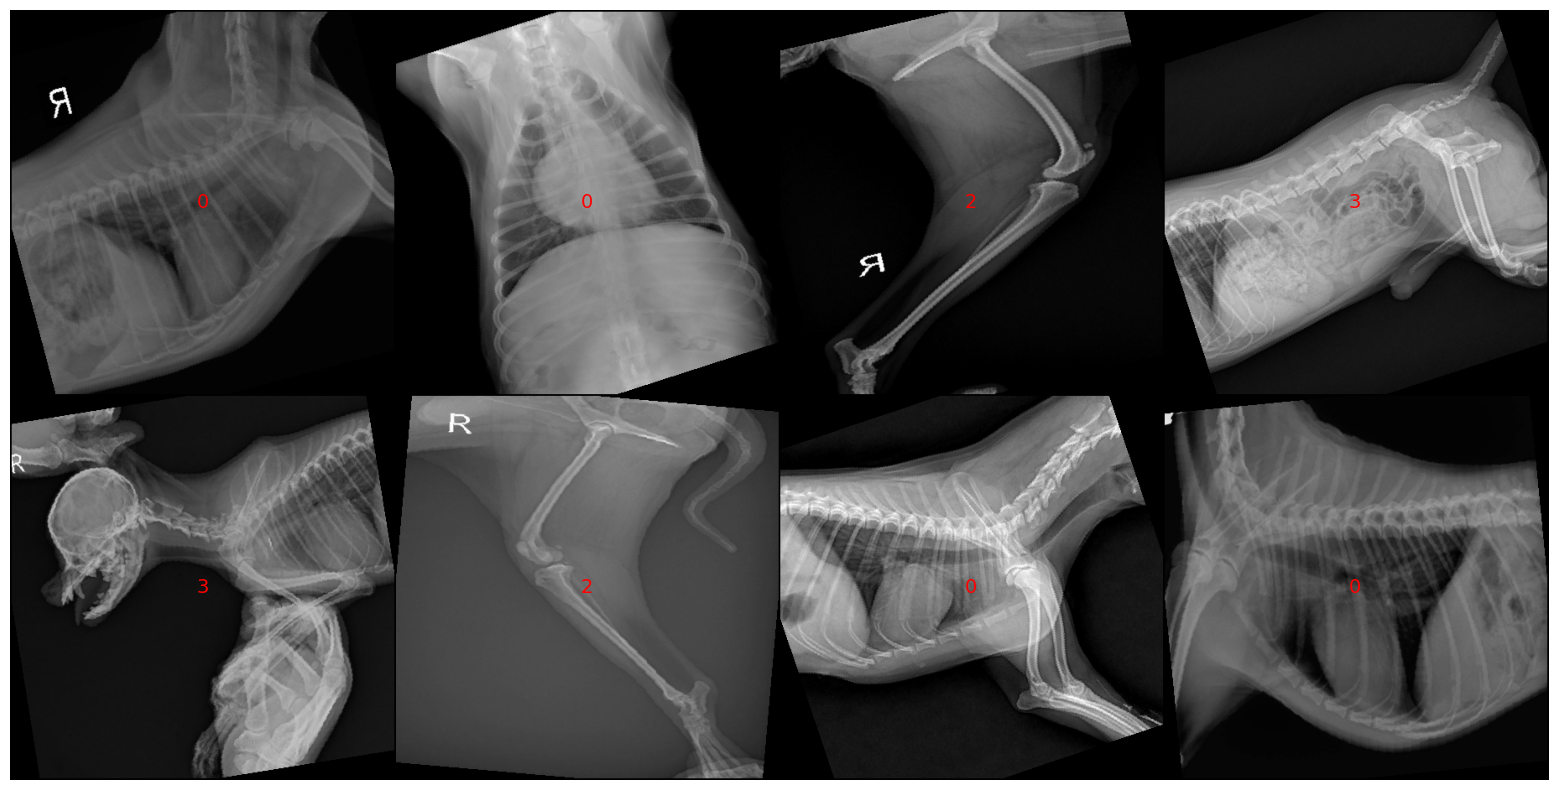

In [ ]:
# DataLoader에서 배치 데이터를 가져옵니다.
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 이미지 그리드 생성 및 시각화
imshow(make_grid(images[:8], nrow=4), labels, size=(30, 10))

In [ ]:
# efficientnet 모델 로드 및 네트워크 구조 확인
efficientnet = models.efficientnet_b5(pretrained=True)

# 모델의 모든 파라미터를 고정
for param in efficientnet.parameters():
    param.requires_grad = False

# classifier의 마지막 레이어를 Binary Classification Task에 맞게 교체하고, 이 레이어의 파라미터는 학습 가능하도록 설정
efficientnet.classifier[1] = nn.Linear(2048, 4)
# efficientnet.classifier[1].requires_grad = True
for param in efficientnet.classifier.parameters():
    param.requires_grad = True

efficientnet = efficientnet.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B5_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# 손실 함수
criterion = nn.CrossEntropyLoss()

In [ ]:
def train_model(optimizer_name, net, train_loader, val_loader, criterion, num_epochs=20):
    # optimizer 설정
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=0.00003, momentum=0.9)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=0.00003, betas=(0.9, 0.999))
    elif optimizer_name == 'RAdam':
        optimizer = optim.RAdam(net.parameters(), lr=0.00003, betas=(0.9, 0.999))
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    # 학습/검증 손실과 검증 정확도를 저장할 리스트
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        net.train()  # 모델을 학습 모드로 설정
        running_loss = 0.0

        # tqdm을 사용하여 진행 상황 표시
        for i, (inputs, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)  # 손실 계산
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # 매 에포크마다 평균 학습 손실 계산
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # 검증 손실 계산
        val_loss = 0.0
        net.eval()  # 모델을 평가 모드로 설정
        correct = 0
        total = 0
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                probabilities = F.softmax(outputs, dim=1) # (로짓 값을 확률로 변환)
                _, predicted = torch.max(probabilities, 1) # (확률로 변환한 값 활용하여 Binacy Classificaion 수행
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)

        # 에폭 종료 후 로그 출력
        print(f'[{optimizer_name}] Epoch {epoch + 1}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.2f}%')

    return train_losses, val_losses, val_accuracies

In [ ]:
train_losses_efficientnet, val_losses_efficientnet, val_accuracies_efficientnet = train_model('Adam', efficientnet, train_loader, val_loader, criterion, num_epochs=30)

Epoch 1/30: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


[Adam] Epoch 1, Train Loss: 1.277165, Val Loss: 1.266541, Validation Accuracy: 72.40%


Epoch 2/30: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


[Adam] Epoch 2, Train Loss: 1.122634, Val Loss: 1.130018, Validation Accuracy: 77.88%


Epoch 3/30: 100%|██████████| 99/99 [00:46<00:00,  2.13it/s]


[Adam] Epoch 3, Train Loss: 0.994924, Val Loss: 1.001781, Validation Accuracy: 81.64%


Epoch 4/30: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


[Adam] Epoch 4, Train Loss: 0.894959, Val Loss: 0.888166, Validation Accuracy: 79.86%


Epoch 5/30: 100%|██████████| 99/99 [00:46<00:00,  2.11it/s]


[Adam] Epoch 5, Train Loss: 0.818770, Val Loss: 0.839815, Validation Accuracy: 78.01%


Epoch 6/30: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


[Adam] Epoch 6, Train Loss: 0.747109, Val Loss: 0.773865, Validation Accuracy: 79.60%


Epoch 7/30: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


[Adam] Epoch 7, Train Loss: 0.688402, Val Loss: 0.717680, Validation Accuracy: 79.92%


Epoch 8/30: 100%|██████████| 99/99 [00:47<00:00,  2.07it/s]


[Adam] Epoch 8, Train Loss: 0.655874, Val Loss: 0.674068, Validation Accuracy: 82.41%


Epoch 9/30: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


[Adam] Epoch 9, Train Loss: 0.608452, Val Loss: 0.628113, Validation Accuracy: 83.62%


Epoch 10/30: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


[Adam] Epoch 10, Train Loss: 0.574767, Val Loss: 0.592938, Validation Accuracy: 84.58%


Epoch 11/30: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


[Adam] Epoch 11, Train Loss: 0.536416, Val Loss: 0.561531, Validation Accuracy: 85.34%


Epoch 12/30: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


[Adam] Epoch 12, Train Loss: 0.522672, Val Loss: 0.542907, Validation Accuracy: 85.79%


Epoch 13/30: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


[Adam] Epoch 13, Train Loss: 0.498068, Val Loss: 0.517737, Validation Accuracy: 86.04%


Epoch 14/30: 100%|██████████| 99/99 [00:47<00:00,  2.06it/s]


[Adam] Epoch 14, Train Loss: 0.472961, Val Loss: 0.489108, Validation Accuracy: 86.49%


Epoch 15/30: 100%|██████████| 99/99 [00:46<00:00,  2.11it/s]


[Adam] Epoch 15, Train Loss: 0.455771, Val Loss: 0.473372, Validation Accuracy: 86.55%


Epoch 16/30: 100%|██████████| 99/99 [00:46<00:00,  2.13it/s]


[Adam] Epoch 16, Train Loss: 0.440197, Val Loss: 0.466323, Validation Accuracy: 86.04%


Epoch 17/30: 100%|██████████| 99/99 [00:46<00:00,  2.11it/s]


[Adam] Epoch 17, Train Loss: 0.420112, Val Loss: 0.447878, Validation Accuracy: 86.30%


Epoch 18/30: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


[Adam] Epoch 18, Train Loss: 0.401912, Val Loss: 0.439098, Validation Accuracy: 86.55%


Epoch 19/30: 100%|██████████| 99/99 [00:48<00:00,  2.06it/s]


[Adam] Epoch 19, Train Loss: 0.392956, Val Loss: 0.416414, Validation Accuracy: 87.57%


Epoch 20/30: 100%|██████████| 99/99 [00:47<00:00,  2.10it/s]


[Adam] Epoch 20, Train Loss: 0.389971, Val Loss: 0.405780, Validation Accuracy: 85.85%


Epoch 21/30: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


[Adam] Epoch 21, Train Loss: 0.374945, Val Loss: 0.396199, Validation Accuracy: 87.64%


Epoch 22/30: 100%|██████████| 99/99 [00:46<00:00,  2.12it/s]


[Adam] Epoch 22, Train Loss: 0.367573, Val Loss: 0.382229, Validation Accuracy: 88.08%


Epoch 23/30: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


[Adam] Epoch 23, Train Loss: 0.356066, Val Loss: 0.379106, Validation Accuracy: 87.51%


Epoch 24/30: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


[Adam] Epoch 24, Train Loss: 0.348922, Val Loss: 0.367022, Validation Accuracy: 87.83%


Epoch 25/30: 100%|██████████| 99/99 [00:47<00:00,  2.10it/s]


[Adam] Epoch 25, Train Loss: 0.341510, Val Loss: 0.351909, Validation Accuracy: 88.97%


Epoch 26/30: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


[Adam] Epoch 26, Train Loss: 0.327057, Val Loss: 0.358978, Validation Accuracy: 87.64%


Epoch 27/30: 100%|██████████| 99/99 [00:47<00:00,  2.09it/s]


[Adam] Epoch 27, Train Loss: 0.324244, Val Loss: 0.353946, Validation Accuracy: 87.64%


Epoch 28/30: 100%|██████████| 99/99 [00:46<00:00,  2.12it/s]


[Adam] Epoch 28, Train Loss: 0.319369, Val Loss: 0.335623, Validation Accuracy: 88.27%


Epoch 29/30: 100%|██████████| 99/99 [00:46<00:00,  2.12it/s]


[Adam] Epoch 29, Train Loss: 0.312112, Val Loss: 0.327477, Validation Accuracy: 89.48%


Epoch 30/30: 100%|██████████| 99/99 [00:47<00:00,  2.10it/s]

[Adam] Epoch 30, Train Loss: 0.325929, Val Loss: 0.329305, Validation Accuracy: 88.66%


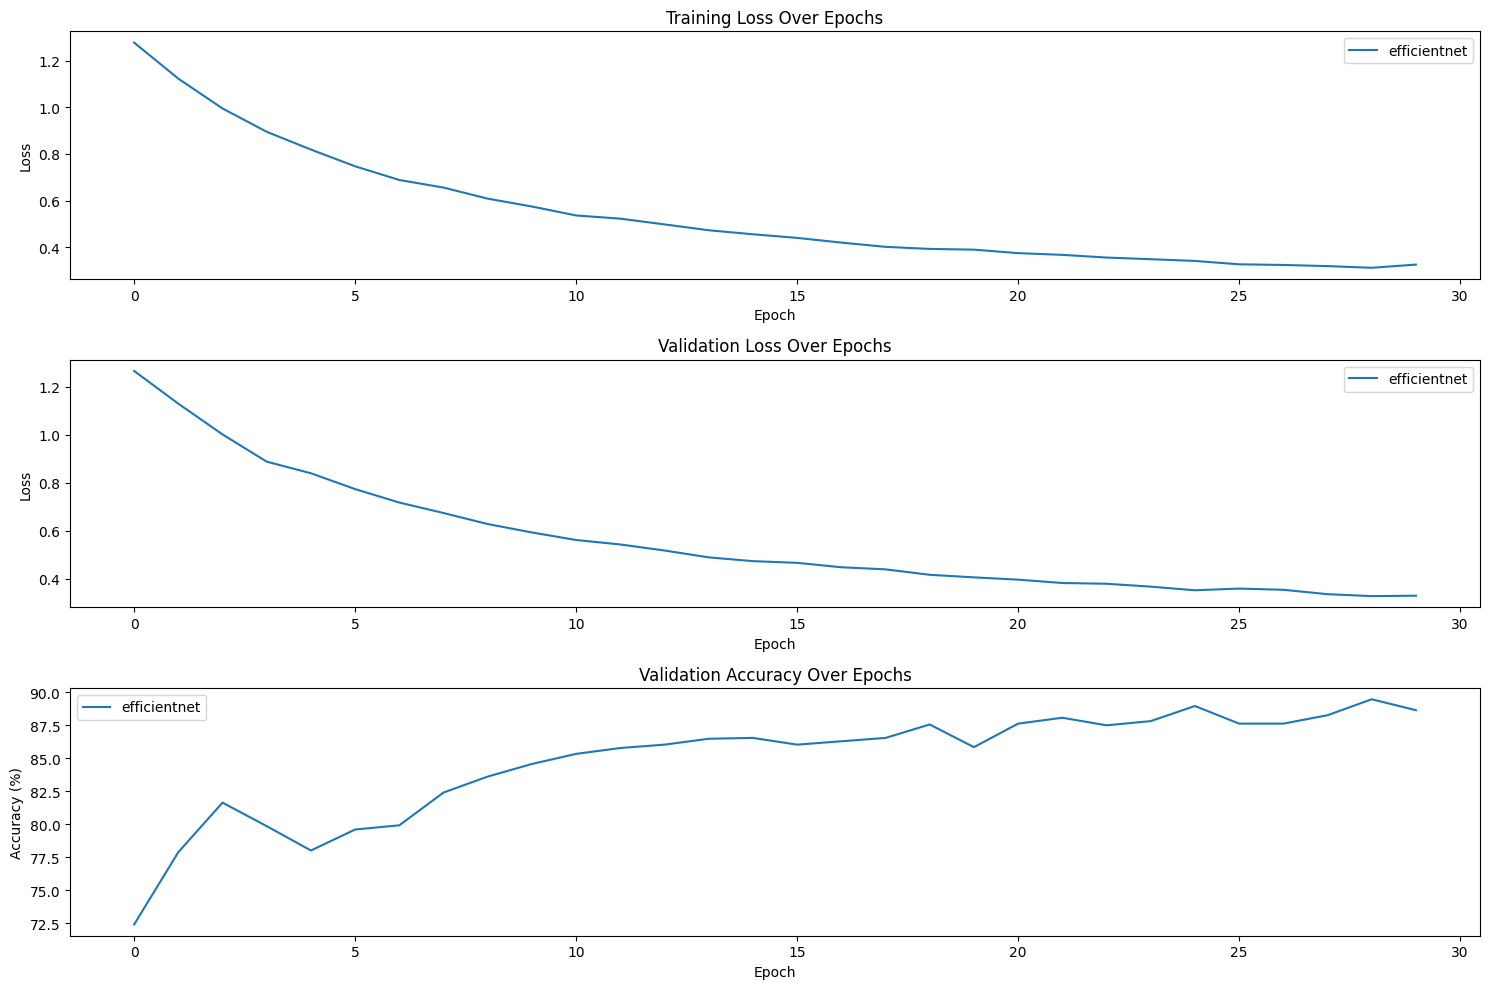

In [ ]:
# 학습 손실과 검증 정확도 그래프 그리기
plt.figure(figsize=(15, 10))

# 학습 손실 그래프
plt.subplot(3, 1, 1)  # 3행 1열의 첫 번째 위치
plt.plot(train_losses_efficientnet, label='efficientnet')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# 검증 손실 그래프
plt.subplot(3, 1, 2)  # 3행 1열의 두 번째 위치
plt.plot(val_losses_efficientnet, label='efficientnet')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()

# 검증 정확도 그래프
plt.subplot(3, 1, 3)  # 3행 1열의 세 번째 위치
plt.plot(val_accuracies_efficientnet, label='efficientnet')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Image load 및 tensor로 변환
def load_and_transform_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0).to(device)  # 이미지를 모델에 맞게 변환하고 배치 차원 추가

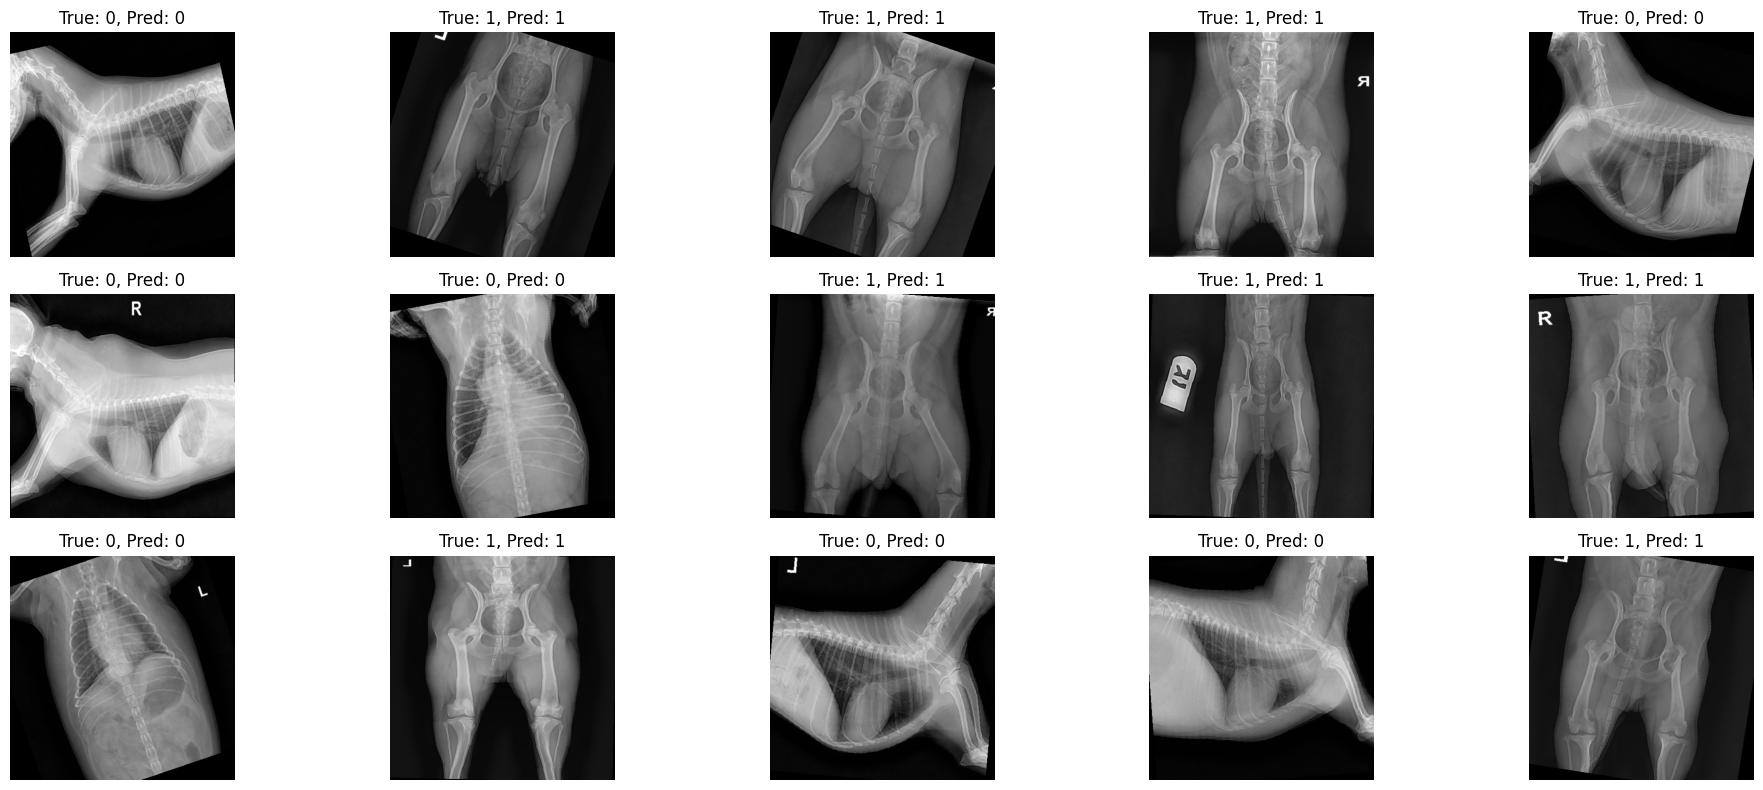

In [ ]:
test_transform = transforms.Compose([
    transforms.Resize((456, 456)),
    transforms.ToTensor(),
])

test_dataset = CustomDataset(root_dir='/content/drive/MyDrive/fastcampus/image_classification/domain/3/test', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

def imshow(tensor, ax, title=None):
    # Convert the tensor to NumPy
    image = tensor.cpu().numpy().transpose((1, 2, 0))
    image = np.clip(image, 0, 1)  # Ensure the image is between 0 and 1

    # Display the image
    ax.imshow(image)
    if title is not None:
        ax.set_title(title)
    ax.axis('off')

plt.figure(figsize=(20, 8))
counter = 1

# Adjust the loop as necessary
for i, (inputs, labels) in enumerate(test_loader):
    inputs, labels = inputs.to(device), labels.to(device)

    if counter > 15:  # Visualize up to 15 images
        break

    efficientnet.eval()
    with torch.no_grad():
        outputs = efficientnet(inputs)
        probabilities = F.softmax(outputs, dim=1)
        _, predicted = torch.max(probabilities, 1)
        prediction = predicted.item()


    ax = plt.subplot(3, 5, counter)
    imshow(inputs.squeeze(), ax, title=f'True: {labels.item()}, Pred: {predicted.item()}')  # Adjust titles as needed

    counter += 1

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, dataset, device='cpu'):
    loader = DataLoader(dataset, batch_size=32, shuffle=False)

    all_preds = []
    all_labels = []

    model.eval()
    model.to(device)

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    return accuracy, precision, recall, f1

In [ ]:
metrics = evaluate_model(efficientnet, test_dataset, device='cuda' if torch.cuda.is_available() else 'cpu')
print(f"Metrics: Accuracy: {metrics[0]:.4f}, Precision: {metrics[1]:.4f}, Recall: {metrics[2]:.4f}, F1: {metrics[3]:.4f}")

Metrics: Accuracy: 0.9601, Precision: 0.9692, Recall: 0.9601, F1: 0.9623


In [ ]:
from sklearn.metrics import classification_report

def evaluate_model_per_class(model, dataset, device='cpu'):
    loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)

    all_preds = []
    all_labels = []

    model.eval()
    model.to(device)

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    # Generate a classification report
    class_names = [name for name, _ in sorted(dataset.disease_to_label.items(), key=lambda x: x[1])]
    report = classification_report(all_labels, all_preds, target_names=class_names, zero_division=0, output_dict=True)

    return report

In [ ]:
report = evaluate_model_per_class(efficientnet, test_dataset, device='cuda' if torch.cuda.is_available() else 'cpu')

# To print out the report in a readable format:
for label, metrics in report.items():
    if label not in ['accuracy', 'macro avg', 'weighted avg']:
        print(f"Class: {label}, Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, F1: {metrics['f1-score']:.4f}")

Class: Mu03, Precision: 0.9943, Recall: 0.9943, F1: 0.9943
Class: Mu05, Precision: 1.0000, Recall: 0.9424, F1: 0.9703
Class: Mu06, Precision: 0.7386, Recall: 1.0000, F1: 0.8497
Class: Mu07, Precision: 0.9286, Recall: 0.9286, F1: 0.9286
